<a href="https://colab.research.google.com/github/cthmayo/covid-diagnosis/blob/main/COVID_Diagnosis_Complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#COVID-19 CT Diagnosis Project



##Introduction

This project is an attempt at diagnosing patients with COVID-19 based on single 2D CT slices, sourced from [here](https://github.com/UCSD-AI4H/COVID-CT). In this project I compared and evaluated a few different methods, including random forests, logistic regression, and two different convolutional neural network architectures.

## Imports and Downloads

In [ ]:
import tensorflow as tf
from tensorflow import keras
import datetime, os
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import cv2 as cv
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

Code to download all images from github and assign to training set, validation set, and test set. This will also crop and resize all images to the same size (400 x 600), without altering the aspect ratio.

In [ ]:
covid_ct_path = keras.utils.get_file('COVID-CT.zip','https://github.com/UCSD-AI4H/COVID-CT/raw/master/Images-processed/CT_COVID.zip')
non_covid_ct_path = keras.utils.get_file('NON-COVID-CT.zip','https://github.com/UCSD-AI4H/COVID-CT/raw/master/Images-processed/CT_NonCOVID.zip')
test_covid_path = keras.utils.get_file('test_covid.txt','https://github.com/UCSD-AI4H/COVID-CT/raw/master/Data-split/COVID/testCT_COVID.txt')
train_covid_path = keras.utils.get_file('train_covid.txt','https://github.com/UCSD-AI4H/COVID-CT/raw/master/Data-split/COVID/trainCT_COVID.txt')
val_covid_path = keras.utils.get_file('val_covid.txt','https://github.com/UCSD-AI4H/COVID-CT/raw/master/Data-split/COVID/valCT_COVID.txt')
test_non_covid_path = keras.utils.get_file('test_non_covid.txt','https://raw.githubusercontent.com/UCSD-AI4H/COVID-CT/master/Data-split/NonCOVID/testCT_NonCOVID.txt')
train_non_covid_path = keras.utils.get_file('train_non_covid.txt','https://github.com/UCSD-AI4H/COVID-CT/raw/master/Data-split/NonCOVID/trainCT_NonCOVID.txt')
val_non_covid_path = keras.utils.get_file('val_non_covid.txt','https://github.com/UCSD-AI4H/COVID-CT/raw/master/Data-split/NonCOVID/valCT_NonCOVID.txt')
with zipfile.ZipFile(covid_ct_path, 'r') as zip_ref:
  zip_ref.extractall('/content')
with zipfile.ZipFile(non_covid_ct_path, 'r') as zip_ref_2:
  zip_ref_2.extractall('/content')
test_covid = open(test_covid_path).read().split('\n')
train_covid = open(train_covid_path).read().split('\n')
val_covid = open(val_covid_path).read().split('\n')
test_non_covid = open(test_non_covid_path).read().split('\n')
train_non_covid = open(train_non_covid_path).read().split('\n')
val_non_covid = open(val_non_covid_path).read().split('\n')

def build_data_and_targets(filenames_covid, filenames_non_covid):
  X = []
  y = []
  for image in filenames_covid:
    if image != '':
      path = '/content/CT_COVID/'+image
      img = keras.preprocessing.image.img_to_array(keras.preprocessing.image.load_img(path))
      X.append(cv.normalize(np.asarray(img), None, 0, 1, cv.NORM_MINMAX) * 255)
      y.append(1)
  for image in filenames_non_covid:
    if image != '':
      path = '/content/CT_NonCOVID/'+image
      img = keras.preprocessing.image.img_to_array(keras.preprocessing.image.load_img(path))
      X.append(cv.normalize(np.asarray(img), None, 0, 1, cv.NORM_MINMAX) * 255)
      y.append(0)
  X = np.asarray(X)
  y = np.asarray(y)
  permutation = np.random.permutation(len(X))
  return X[permutation] / 255, y[permutation]

# will chop all images to a 3:2 ratio and resize to 400 x 600
def chop_and_resize(image):
  if image.shape[1] / image.shape[0] > 3 / 2:
    long_dim = image.shape[1]
    short_dim = image.shape[0]
    desired_long_dim = int(short_dim * 3 / 2)
    difference_to_chop = long_dim - desired_long_dim
    image_chopped = image[:,int(difference_to_chop / 2) : long_dim - int(difference_to_chop / 2)]
    return tf.image.resize(image_chopped,[400,600]).numpy()
  elif image.shape[1] / image.shape[0] < 3 / 2:
    long_dim = image.shape[0]
    short_dim = image.shape[1]
    desired_long_dim = int(short_dim * 2 / 3)
    difference_to_chop = long_dim - desired_long_dim
    image_chopped = image[int(difference_to_chop / 2) : long_dim - int(difference_to_chop / 2),:]
    return tf.image.resize(image_chopped,[400,600]).numpy()
  else:
    return tf.image.resize(image,[400,600]).numpy()

X_test, y_test = build_data_and_targets(test_covid, test_non_covid)
X_val, y_val = build_data_and_targets(val_covid, val_non_covid)
X_train, y_train = build_data_and_targets(train_covid, train_non_covid)
X_train = np.asarray([chop_and_resize(image) for image in X_train])
X_val = np.asarray([chop_and_resize(image) for image in X_val])
X_test = np.asarray([chop_and_resize(image) for image in X_test])

8192/551 [==============================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


## Useful Methods

Methods to show the pictures and evaluate predictions.

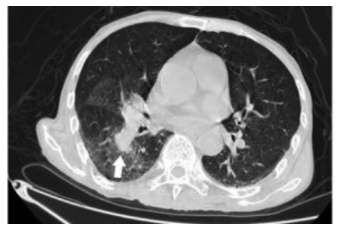

In [ ]:
def show_pic(pic):
  plt.imshow(pic,cmap='gray')
  plt.axis('off')
  plt.show()
show_pic(X_train[100])

In [ ]:
def evaluate_predictions(true, predicted):
  acc = accuracy_score(true, predicted)
  auc = roc_auc_score(true, predicted)
  f1 = f1_score(true, predicted)
  return acc, auc, f1

## Logistic Regression Classification

Using sklearn. This essentially involves flattening the picture and feeding the raw pixel values into sklearn's logistic regression.



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
log_clf = LogisticRegression()
log_clf.fit(X_train.reshape((425,720000)),y_train)
log_pred = log_clf.predict(X_val.reshape((118,720000)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
evaluate_predictions(y_val,log_pred)

(0.5847457627118644, 0.5844827586206897, 0.5950413223140496)

Visualising the coefficients generated by logistic regression...

In [ ]:
coef = log_clf.coef_
coef = coef[0] / max(coef[0])
coef = (coef + 1) / 2

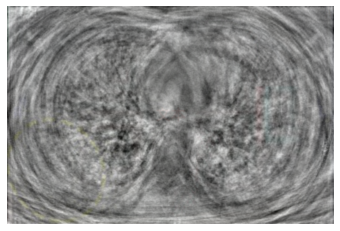

In [ ]:
show_pic(coef.reshape(400,600,3))

Ultimately the results generated by logistic regression are poor according to the validation set, and although the coefficients generate a pretty image, it's still not totally clear what is going on.

## Random Forest Classification

Again, this essentially involves flattening the image and then feeding it through sklearn's random forest classifier.

In [ ]:
tree_clf = RandomForestClassifier()
tree_clf.fit(X_train.reshape((425,720000)),y_train)
tree_pred = tree_clf.predict(X_val.reshape((118,720000)))

In [ ]:
evaluate_predictions(y_val,tree_pred)

(0.7288135593220338, 0.7278735632183908, 0.746031746031746)

Visualising feature importances is more difficult with random forests because there are only a few thousand pixels in the image with non-zero importance...

In [ ]:
feat = tree_clf.feature_importances_
feat = feat.reshape((400,600,3))
feat_locations = np.nonzero(feat)

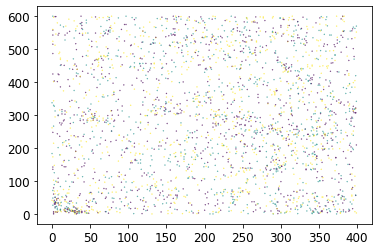

In [ ]:
plt.scatter(feat_locations[0], feat_locations[1], c=feat_locations[2], s=0.1)

There are no clear patterns in terms of feature importance, besides the corner closest to the origin being favoured.

## Convolutional Neural Networks

In [ ]:
def compile_and_train_cnn(model):
  model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Nadam(learning_rate=1e-05),
              metrics=['accuracy'])
  early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=100,restore_best_weights=True)
  history = model.fit(X_train,y_train,epochs=3000,validation_data=(X_val,y_val),callbacks=[early_stopping_cb])

### Basic CNN
A basic CNN architecture with convolutional layers, batch normalisation, and max pooling. 

In [ ]:
cnn_basic = keras.models.Sequential([
    keras.layers.BatchNormalization(input_shape=(400,600,3)),
    keras.layers.Conv2D(8, 3, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(16, 3, activation='relu', padding='valid'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(32, 5, activation='relu', padding='valid'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(64, 5, activation='relu', padding='valid'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(256, 7, activation='relu', padding='valid'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
cnn_basic.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 400, 600, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 400, 600, 8)       224       
_________________________________________________________________
batch_normalization_1 (Batch (None, 400, 600, 8)       32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 200, 300, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 198, 298, 16)      1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 198, 298, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 149, 16)       0

In [ ]:
compile_and_train_cnn(cnn_basic)

Epoch 1/3000
14/14 [==============================] - 4s 272ms/step - loss: 0.8178 - accuracy: 0.5529 - val_loss: 0.6924 - val_accuracy: 0.5339
Epoch 2/3000
14/14 [==============================] - 3s 197ms/step - loss: 0.3459 - accuracy: 0.8776 - val_loss: 0.6931 - val_accuracy: 0.5085
Epoch 3/3000
14/14 [==============================] - 3s 200ms/step - loss: 0.2298 - accuracy: 0.9247 - val_loss: 0.7050 - val_accuracy: 0.5085
Epoch 4/3000
14/14 [==============================] - 3s 198ms/step - loss: 0.1681 - accuracy: 0.9741 - val_loss: 0.7221 - val_accuracy: 0.5085
Epoch 5/3000
14/14 [==============================] - 3s 198ms/step - loss: 0.1293 - accuracy: 0.9788 - val_loss: 0.7425 - val_accuracy: 0.5085
Epoch 6/3000
14/14 [==============================] - 3s 200ms/step - loss: 0.1187 - accuracy: 0.9788 - val_loss: 0.7887 - val_accuracy: 0.5085
Epoch 7/3000
14/14 [==============================] - 3s 202ms/step - loss: 0.0866 - accuracy: 0.9953 - val_loss: 0.8251 - val_accuracy:

In [ ]:
evaluate_predictions(y_val, (cnn_basic.predict(X_val) > 0.5).astype("int32"))

(0.7288135593220338, 0.728448275862069, 0.7377049180327869)

### DenseNet169
Now I will train the data on DenseNet169 and see if it performs differently.

In [ ]:
# will preprocess into a grayscale, 224x224 image, which is needed for DenseNet169
@tf.function
def resize_images(images, labels = None):
  processed_images = tf.convert_to_tensor(images)
  processed_images = tf.image.resize(processed_images,[224,224])
  if labels == None:
    return processed_images
  return processed_images, labels

In [ ]:
densenet = keras.models.Sequential([
                                   keras.layers.Input(shape=(400,600,3)),
                                   keras.layers.Lambda(resize_images),
                                   keras.layers.Lambda(lambda x: keras.applications.densenet.preprocess_input(x)),
                                   keras.applications.DenseNet169(include_top=False,pooling='avg'),
                                   keras.layers.Dense(1, activation='sigmoid')
])

51879936/51877672 [==============================] - 1s 0us/step


In [ ]:
compile_and_train_cnn(densenet)

Epoch 1/3000
14/14 [==============================] - 12s 834ms/step - loss: 0.8018 - accuracy: 0.4729 - val_loss: 0.6820 - val_accuracy: 0.5508
Epoch 2/3000
14/14 [==============================] - 7s 465ms/step - loss: 0.5784 - accuracy: 0.6471 - val_loss: 0.6627 - val_accuracy: 0.6610
Epoch 3/3000
14/14 [==============================] - 6s 454ms/step - loss: 0.4308 - accuracy: 0.8141 - val_loss: 0.6676 - val_accuracy: 0.5932
Epoch 4/3000
14/14 [==============================] - 6s 456ms/step - loss: 0.3209 - accuracy: 0.9153 - val_loss: 0.6859 - val_accuracy: 0.5339
Epoch 5/3000
14/14 [==============================] - 6s 456ms/step - loss: 0.2453 - accuracy: 0.9718 - val_loss: 0.7118 - val_accuracy: 0.4831
Epoch 6/3000
14/14 [==============================] - 6s 458ms/step - loss: 0.1884 - accuracy: 0.9882 - val_loss: 0.7230 - val_accuracy: 0.5169
Epoch 7/3000
14/14 [==============================] - 6s 460ms/step - loss: 0.1922 - accuracy: 0.9600 - val_loss: 0.7448 - val_accuracy

In [ ]:
evaluate_predictions(y_val, (densenet.predict(X_val) > 0.5).astype("int32"))

(0.7288135593220338, 0.7307471264367816, 0.6981132075471699)

## Convolutional Neural Networks II
Using the same networks and strategies but using data augmentation. Data augmentation is done using ImageDataGenerator from Keras.

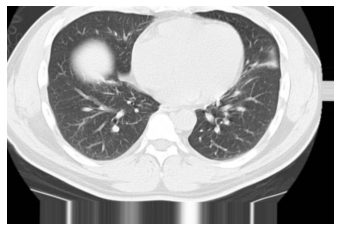

In [ ]:
datagen = keras.preprocessing.image.ImageDataGenerator(width_shift_range=[-40,-20,20,40],height_shift_range=[-40,-20,20,40],rotation_range=10)
it = datagen.flow(X_train, y_train, batch_size=32)
show_pic(it.next()[0][0])

In [ ]:
def compile_and_train_cnn_augmented(model):
  datagen = keras.preprocessing.image.ImageDataGenerator(width_shift_range=[-40,-20,20,40],height_shift_range=[-40,-20,20,40],rotation_range=10)
  it = datagen.flow(X_train, y_train, batch_size=32)
  model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Nadam(learning_rate=1e-05),
              metrics=['accuracy'])
  early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=100,restore_best_weights=True)
  history = model.fit(it,epochs=3000,validation_data=(X_val,y_val),callbacks=[early_stopping_cb])

### Basic CNN
Again, the same basic model from the previous section...

In [ ]:
cnn_basic_a = keras.models.Sequential([
    keras.layers.BatchNormalization(input_shape=(400,600,3)),
    keras.layers.Conv2D(8, 3, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(16, 3, activation='relu', padding='valid'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(32, 5, activation='relu', padding='valid'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(64, 5, activation='relu', padding='valid'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(256, 7, activation='relu', padding='valid'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
compile_and_train_cnn_augmented(cnn_basic_a)

Epoch 1/3000
14/14 [==============================] - 18s 1s/step - loss: 0.7906 - accuracy: 0.5600 - val_loss: 0.6951 - val_accuracy: 0.5085
Epoch 2/3000
14/14 [==============================] - 18s 1s/step - loss: 0.7057 - accuracy: 0.6306 - val_loss: 0.7020 - val_accuracy: 0.5085
Epoch 3/3000
14/14 [==============================] - 18s 1s/step - loss: 0.6237 - accuracy: 0.6847 - val_loss: 0.7240 - val_accuracy: 0.5085
Epoch 4/3000
14/14 [==============================] - 18s 1s/step - loss: 0.5867 - accuracy: 0.7012 - val_loss: 0.7412 - val_accuracy: 0.5085
Epoch 5/3000
14/14 [==============================] - 18s 1s/step - loss: 0.5369 - accuracy: 0.7012 - val_loss: 0.7836 - val_accuracy: 0.5085
Epoch 6/3000
14/14 [==============================] - 18s 1s/step - loss: 0.4899 - accuracy: 0.7671 - val_loss: 0.8712 - val_accuracy: 0.5085
Epoch 7/3000
14/14 [==============================] - 18s 1s/step - loss: 0.4681 - accuracy: 0.7694 - val_loss: 0.9791 - val_accuracy: 0.5085
Epoch 

In [ ]:
evaluate_predictions(y_val, (cnn_basic_a.predict(X_val) > 0.5).astype("int32"))

(0.7203389830508474, 0.7169540229885056, 0.7692307692307692)

### DenseNet169

In [ ]:
densenet_a = keras.models.Sequential([
                                   keras.layers.Input(shape=(400,600,3)),
                                   keras.layers.Lambda(resize_images),
                                   keras.layers.Lambda(lambda x: keras.applications.densenet.preprocess_input(x)),
                                   keras.applications.DenseNet169(include_top=False,pooling='avg'),
                                   keras.layers.Dense(1, activation='sigmoid')
])

In [29]:
compile_and_train_cnn_augmented(densenet_a)

14/14 [==============================] - 19s 1s/step - loss: 0.3868 - accuracy: 0.8659 - val_loss: 0.7994 - val_accuracy: 0.5085
Epoch 8/3000
Epoch 8/3000
14/14 [==============================] - 19s 1s/step - loss: 0.3612 - accuracy: 0.8682 - val_loss: 0.8223 - val_accuracy: 0.5085
Epoch 9/3000
Epoch 9/3000
14/14 [==============================] - 20s 1s/step - loss: 0.3314 - accuracy: 0.8847 - val_loss: 0.7983 - val_accuracy: 0.5000
Epoch 10/3000
Epoch 10/3000
14/14 [==============================] - 19s 1s/step - loss: 0.3209 - accuracy: 0.8541 - val_loss: 0.7822 - val_accuracy: 0.4746
Epoch 11/3000
Epoch 11/3000
14/14 [==============================] - 19s 1s/step - loss: 0.2954 - accuracy: 0.8941 - val_loss: 0.9051 - val_accuracy: 0.5085
Epoch 12/3000
Epoch 12/3000
14/14 [==============================] - 21s 1s/step - loss: 0.2774 - accuracy: 0.8988 - val_loss: 0.7557 - val_accuracy: 0.4746
Epoch 13/3000
Epoch 13/3000
14/14 [==============================] - 19s 1s/step - loss: 0

In [30]:
evaluate_predictions(y_val, (densenet.predict(X_val) > 0.5).astype("int32"))

(0.7288135593220338, 0.7307471264367816, 0.6981132075471699)

## CNN Interpretation using Lime
For each network, I will pick the two images in the validation set that the network is most confident about (one positive and one negative examples) and see what parts of the image the network is actually looking at.


In [33]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [34]:
def explain_prediction(image, model):
  explainer = lime_image.LimeImageExplainer()
  explanation = explainer.explain_instance(image, model.predict, hide_color=0, num_samples=1000)
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
  plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [35]:
X_val_positives = np.asarray([image for image, label in zip(X_val, y_val) if label == 1])
X_val_negatives = np.asarray([image for image, label in zip(X_val, y_val) if label == 0])

In [36]:
def get_best_predictions(model):
  predictions_positives = np.asarray([prediction[0] for prediction in model.predict(X_val_positives)])
  predictions_negatives = np.asarray([prediction[0] for prediction in model.predict(X_val_negatives)])
  top_positive = np.argmax(predictions_positives)
  top_negative = np.argmin(predictions_negatives)
  return top_positive, top_negative

###Basic CNN (No Augmentation)

In [50]:
top_positive, top_negative = get_best_predictions(cnn_basic)

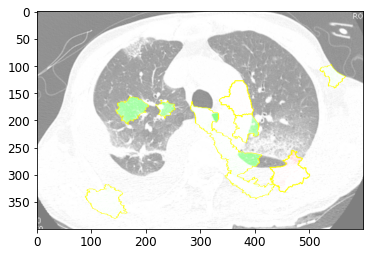

In [51]:
explain_prediction(X_val_positives[top_positive], cnn_basic)

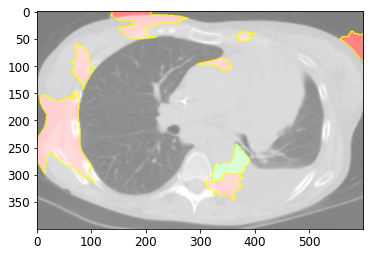

In [53]:
explain_prediction(X_val_negatives[top_negative], cnn_basic)

### DenseNet169 (No Augmentation)

In [54]:
top_positive, top_negative = get_best_predictions(densenet)

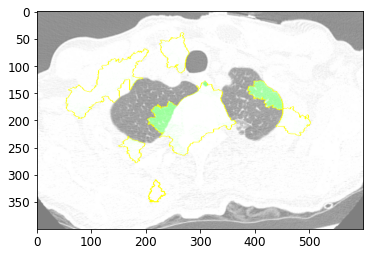

In [55]:
explain_prediction(X_val_positives[top_positive], densenet)

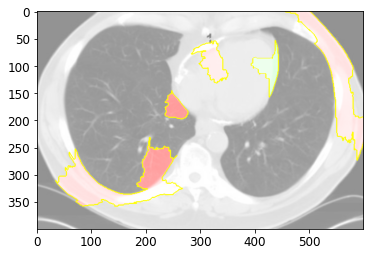

In [56]:
explain_prediction(X_val_negatives[top_negative], densenet)

### Basic CNN (With Augmentation)

In [57]:
top_positive, top_negative = get_best_predictions(cnn_basic_a)

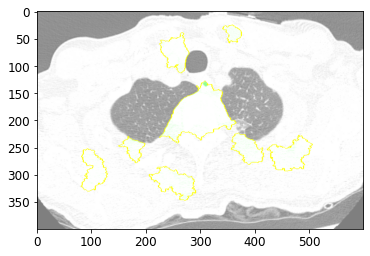

In [58]:
explain_prediction(X_val_positives[top_positive], cnn_basic_a)

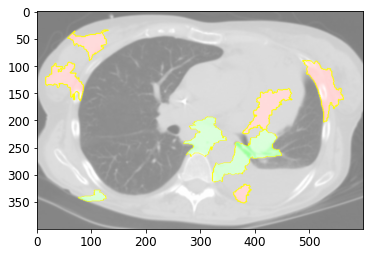

In [59]:
explain_prediction(X_val_negatives[top_negative], cnn_basic_a)

### DenseNet169 (With Augmentation)

In [60]:
top_positive, top_negative = get_best_predictions(densenet_a)

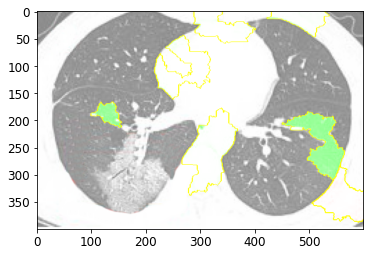

In [61]:
explain_prediction(X_val_positives[top_positive], densenet_a)

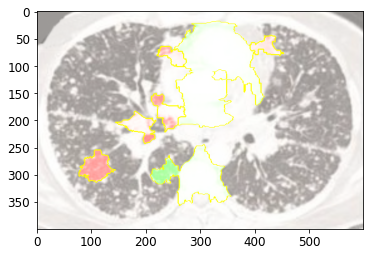

In [62]:
explain_prediction(X_val_negatives[top_negative], densenet_a)

## Final Evaluation on Test Set

### Logistic Regression


In [63]:
evaluate_predictions(y_test,log_clf.predict(X_test.reshape((-1,720000))))

(0.6354679802955665, 0.6333333333333333, 0.6021505376344085)

### Random Forests

In [64]:
evaluate_predictions(y_test,tree_clf.predict(X_test.reshape((-1,720000))))

(0.7044334975369458, 0.7040816326530612, 0.6938775510204082)

###Basic CNN (No Augmentation)

In [65]:
evaluate_predictions(y_test, (cnn_basic.predict(X_test) > 0.5).astype("int32"))

(0.645320197044335, 0.6465986394557823, 0.6504854368932039)

### DenseNet169 (No Augmentation)

In [66]:
evaluate_predictions(y_test, (densenet.predict(X_test) > 0.5).astype("int32"))

(0.729064039408867, 0.7275510204081633, 0.7089947089947091)

### Basic CNN (With Augmentation)

In [67]:
evaluate_predictions(y_test, (cnn_basic_a.predict(X_test) > 0.5).astype("int32"))

(0.6206896551724138, 0.6241496598639455, 0.6484018264840183)

### DenseNet169 (With Augmentation)

In [68]:
evaluate_predictions(y_test, (densenet_a.predict(X_test) > 0.5).astype("int32"))

(0.7339901477832512, 0.7340136054421769, 0.7272727272727272)

## Conclusion

The strongest classifiers for diagnosing COVID from CT scans are DenseNet169 (with and without data augmentation) and random forest classifiers, all with over 70% accuracy, over 70% AUC, and over 70% F1.

The Basic CNN is significantly weaker, with only around a little over 60% accuracy. Furthermore, according to Lime, the deciding features for classification are often outside the lungs for the Basic CNN, whereas DenseNet169 detects deciding features within the lungs, which is what would be expected when diagnosing or excluding COVID.

Data augmentation does not appear to make any significant difference.